## SSPS Demo 
## Preprocessing Data Input Tables Site Specific RShiny Demo App
Notes:
- asdf

In [1]:
# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd # the library that lets us read in shapefiles
import geoplot as gplt # for plotting maps

# visulizaiton
import seaborn as sns
import matplotlib.pyplot as plt

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [2]:
# Setting work directory
cwd = os.getcwd()
print("current directory = " + cwd)

os.chdir("../NotEssentialData")
print("new directory = " + os.path.abspath(os.curdir))

current directory = C:\Users\rjame\Documents\WSWC Documents\WaDE Side Projects Local\20221017 Rshiny SS Demo\SSPS_Demo\bonus code
new directory = C:\Users\rjame\Documents\WSWC Documents\WaDE Side Projects Local\20221017 Rshiny SS Demo\SSPS_Demo\NotEssentialData


## Inputs

In [3]:
#Sites Input
fileInput = "Sites.csv"
dfs = pd.read_csv(fileInput)
print(len(dfs))
dfs.head(1)

73985


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,PopulationServed,WaDENameBU,HasRecords
0,CAssps_S1062,SO. CAL. EDISON CO.-SANTA CATALINA,CA1910006,Unspecified,-118.434483,33.382597,POU,Groundwater,Monthly,Delivered,Delivered,Cumulative Delivered_Monthly_Agricultural_Unsp...,4096.0,Agriculture Irrigation,Yes


## Clean Sites Data

In [4]:
# Clean input.  Remove no value sites

dfs = dfs.drop_duplicates() # Drop Duplicate Rows
dfs = dfs.dropna(subset=['VariableSpecificCV']).reset_index(drop=True) # drop no value sites
dfs = dfs.replace(np.nan, "")  # Replaces NaN values with blank.
print(len(dfs))
dfs.head(1)

68830


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,PopulationServed,WaDENameBU,HasRecords
0,CAssps_S1062,SO. CAL. EDISON CO.-SANTA CATALINA,CA1910006,Unspecified,-118.434483,33.382597,POU,Groundwater,Monthly,Delivered,Delivered,Cumulative Delivered_Monthly_Agricultural_Unsp...,4096.0,Agriculture Irrigation,Yes


In [5]:
# Convert PopulationServed to numeric.
# Convert to int, ignore NA values.
dfs['PopulationServed'] = pd.to_numeric(dfs['PopulationServed'], errors='coerce')
dfs['PopulationServed'] = dfs['PopulationServed'].astype('Int64')
print(dfs['PopulationServed'].min())
print(dfs['PopulationServed'].max())

0
4061504


In [6]:
# Fixing blank WaDENameS
def updateWaDENameS(Val):
    Val = str(Val).strip()
    if Val == "" or pd.isnull(Val) or Val == "":
        outString = "Unspecified"
    else:
        outString = Val
    return outString

dfs['WaDENameS'] = dfs.apply(lambda row: updateWaDENameS(row['WaDENameS']), axis=1)
for x in dfs['WaDENameS'].sort_values().unique():
    print(f'"' + x + '",')

"City / District",
"Lake",
"Reservoir",
"Stream Gage",
"Surface Water Point",
"Unspecified",
"Well / Pump / Spring / Groundwater Point",


In [7]:
# Fixing blank WaDENameWS
def updateWaDENameWS(Val):
    Val = str(Val).strip()
    if Val == "" or pd.isnull(Val) or Val == "":
        outString = "Unspecified"
    else:
        outString = Val
    return outString

dfs['WaDENameWS'] = dfs.apply(lambda row: updateWaDENameWS(row['WaDENameWS']), axis=1)
for x in dfs['WaDENameWS'].sort_values().unique():
    print(f'"' + x + '",')

"Groundwater",
"Reuse",
"Surface Water",
"Surface and Groundwater",
"Unspecified",


In [8]:
# Fixing blank WaDENameBU
def updateWaDENameBU(Val):
    Val = str(Val).strip()
    if Val == "" or pd.isnull(Val) or Val == "":
        outString = "Unspecified"
    else:
        outString = Val
    return outString

dfs['WaDENameBU'] = dfs.apply(lambda row: updateWaDENameBU(row['WaDENameBU']), axis=1)
for x in dfs['WaDENameBU'].sort_values().unique():
    print(f'"' + x + '",')

"Agriculture Irrigation",
"Commercial/Industrial",
"Domestic",
"Hydroelectric",
"Mining",
"Municipal Irrigation",
"Other",
"Public Supply",
"Thermoelectric Cooling",
"Treated Wastewater/Reuse",
"Unspecified",


In [9]:
# Fixing blank WaDENameV
def updateWaDENameV(Val):
    Val = str(Val).strip()
    if Val == "" or pd.isnull(Val) or Val == "":
        outString = "Unspecified"
    else:
        outString = Val
    return outString

dfs['WaDENameV'] = dfs.apply(lambda row: updateWaDENameBU(row['WaDENameV']), axis=1)
for x in dfs['WaDENameV'].sort_values().unique():
    print(f'"' + x + '",')

"Consumptive Use",
"Delivered",
"Produced",
"Return",
"Withdrawal",


In [10]:
for x in dfs['TimeStep'].sort_values().unique():
    print(f'"' + x + '",')

"Annual",
"Monthly",


In [11]:
# add State field

def createState(Val):
    Val = Val.strip()
    outString = Val[:2]
    return outString

dfs['State'] = dfs.apply(lambda row: createState(row['SiteUUID']), axis=1)
for x in dfs['State'].sort_values().unique():
    print(f'"' + x + '",')

"CA",
"NJ",
"NM",
"TX",
"UT",


In [12]:
# Groupby SiteUUID
#dfs = dfs.groupby(['SiteUUID']).agg(lambda x: ", ".join([str(elem) for elem in (list(set(x))) if elem!=""])).replace(np.nan, "").reset_index()
dfs = dfs.groupby(['SiteUUID']).agg(lambda x: ", ".join([str(elem) for elem in (list(set(x)))])).replace(np.nan, "").reset_index()
print(len(dfs))
dfs.head(1)

12936


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,PopulationServed,WaDENameBU,HasRecords,State
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Unspecified,-122.027303326,37.7343636266,POU,"Surface Water, Groundwater, Unspecified",Monthly,"Produced, Delivered","Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,50,"Public Supply, Unspecified",Yes,CA


In [13]:
# count num of VariableSpecificCV after groupby

def countNumVar(Val):
    Val = list(Val.split(","))
    if Val == [""]:
        ValLen = 0
    else:
        ValLen = len(Val)
    return ValLen

dfs['CountVar'] = dfs.apply(lambda row: countNumVar(row['VariableSpecificCV']), axis=1)
for x in dfs['CountVar'].sort_values().unique():
    print(f'"' + str(x) + '",')

"1",
"2",
"3",
"4",
"5",
"6",
"7",
"8",
"9",
"10",
"11",
"12",


In [14]:
# attach timeframe based on SiteUUID

fileInput = "Sites_timeframe.csv"
dfstf = pd.read_csv(fileInput)
dfs = pd.merge(dfs, dfstf, on='SiteUUID', how='left')
print(len(dfs))
dfs.head(1)

12936


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,PopulationServed,WaDENameBU,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Unspecified,-122.027303326,37.7343636266,POU,"Surface Water, Groundwater, Unspecified",Monthly,"Produced, Delivered","Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,50,"Public Supply, Unspecified",Yes,CA,2,2014-01-01,2016-12-31


In [15]:
# attach geometry based on SiteUUID

fileInput = "Sites_geometry.csv"
dfgeo = pd.read_csv(fileInput)
dfs = pd.merge(dfs, dfgeo, on='SiteUUID', how='left')
print(len(dfs))
dfs.head(1)

12936


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite_x,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,PopulationServed,WaDENameBU,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd,PODorPOUSite_y,geometry
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Unspecified,-122.027303326,37.7343636266,POU,"Surface Water, Groundwater, Unspecified",Monthly,"Produced, Delivered","Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,50,"Public Supply, Unspecified",Yes,CA,2,2014-01-01,2016-12-31,POU,POLYGON ((-122.02636000038909 37.7379799998779...


In [16]:
# Temp Fix

# remove lat & long entries that contain a ','
dfs = dfs[dfs['Latitude'].str.contains(',') == False]
dfs = dfs[dfs['Longitude'].str.contains(',') == False]

# Ensure long is < 0 and > -125 (few ID sites out of bounds)
# Ensure lat is > 10 and < 50 (few MT sites out of bounds).
dfs['Latitude'] = pd.to_numeric(dfs['Latitude'], errors='coerce')
dfs['Longitude'] = pd.to_numeric(dfs['Longitude'], errors='coerce')
dfs = dfs[(dfs['Latitude'].astype(int) > 10) & (dfs['Latitude'].astype(int) < 50)]
dfs = dfs[(dfs['Longitude'].astype(int) < 0) & (dfs['Longitude'].astype(int) > -125)]

print(len(dfs))
dfs.head(1)

12936


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite_x,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,PopulationServed,WaDENameBU,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd,PODorPOUSite_y,geometry
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Unspecified,-122.027303,37.734364,POU,"Surface Water, Groundwater, Unspecified",Monthly,"Produced, Delivered","Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,50,"Public Supply, Unspecified",Yes,CA,2,2014-01-01,2016-12-31,POU,POLYGON ((-122.02636000038909 37.7379799998779...


In [17]:
# # Issue of ESRI Shapefile does not support datetime fields

# dfs['minTimeFrameStart'] = pd.to_datetime(dfs['minTimeFrameStart'], errors = 'coerce')
# dfs['maxTimeFrameEnd'] = pd.to_datetime(dfs['maxTimeFrameEnd'], errors = 'coerce')
# print(dfs['minTimeFrameStart'].min())
# print(dfs['maxTimeFrameEnd'].max())

In [18]:
#Inspect output
dfs

,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite_x,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,PopulationServed,WaDENameBU,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd,PODorPOUSite_y,geometry
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Unspecified,-122.027303,37.734364,POU,"Surface Water, Groundwater, Unspecified",Monthly,"Produced, Delivered","Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,50,"Public Supply, Unspecified",Yes,CA,2,2014-01-01,2016-12-31,POU,POLYGON ((-122.02636000038909 37.7379799998779...
1,CAssps_S10,ALAMEDA COUNTY FAIRGROUNDS,CA0105020,Unspecified,-121.887236,37.661659,POU,"Surface Water, Groundwater, Unspecified",Monthly,"Produced, Delivered","Produced, Delivered","Cumulative Produced_Monthly_Total_Groundwater,...",82,"Municipal Irrigation, Public Supply, Unspecified",Yes,CA,3,2013-01-01,2016-12-31,POU,POLYGON ((-121.88789999944797 37.6622299998386...
2,CAssps_S100,FOREST RANCH CHARTER SCHOOL,CA0400079,Unspecified,-121.667045,39.884413,POU,"Surface Water, Groundwater, Unspecified",Monthly,Produced,Produced,Cumulative Produced_Monthly_Total_Groundwater,146,Unspecified,Yes,CA,1,2014-01-01,2016-12-31,POU,POLYGON ((-121.6677100001466 39.88542000026367...
3,CAssps_S1000,LANCASTER PARK MOBILE HOME PARK,CA1900038,Unspecified,-118.131822,34.746266,POU,"Surface Water, Groundwater, Unspecified",Monthly,Produced,Produced,Cumulative Produced_Monthly_Total_Groundwater,61,Unspecified,Yes,CA,1,2016-01-01,2016-12-31,POU,POLYGON ((-118.13252999981032 34.7459100000641...
4,CAssps_S1001,PETER PITCHESS HONOR RANCHO DETN. CTR,CA1900046,Unspecified,-118.595689,34.465742,POU,"Surface Water, Groundwater, Unspecified",Monthly,Produced,Produced,Cumulative Produced_Monthly_Total_Groundwater,7500,Unspecified,Yes,CA,1,2013-01-01,2016-12-31,POU,MULTIPOLYGON (((-118.60232725927787 34.4652590...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12931,UTssps_S995,Well #1,POD108542928,Well / Pump / Spring / Groundwater Point,-112.098703,41.256292,POD,Groundwater,Annual,Withdrawal,Withdrawal,Withdrawal_Monthly_Agricultural_Groundwater,0,Agriculture Irrigation,Yes,UT,1,2015-01-01,2021-12-31,POD,NaN
12932,UTssps_S996,Well #2,POD108542932,Well / Pump / Spring / Groundwater Point,-112.093757,41.256369,POD,Groundwater,Annual,Withdrawal,Withdrawal,Withdrawal_Monthly_Agricultural_Groundwater,0,Agriculture Irrigation,Yes,UT,1,2015-01-01,2021-12-31,POD,NaN
12933,UTssps_S997,Tollgate Well #3 (WS003),POD108542937,Well / Pump / Spring / Groundwater Point,-111.498348,40.796333,POD,Groundwater,Annual,Withdrawal,Withdrawal,Withdrawal_Monthly_Water Supplier_Groundwater,0,Public Supply,Yes,UT,1,2013-01-01,2021-12-31,POD,NaN
12934,UTssps_S998,Contact (#1) Well (WS004),POD108542958,Well / Pump / Spring / Groundwater Point,-111.511629,40.805735,POD,Groundwater,Annual,Withdrawal,Withdrawal,Withdrawal_Monthly_Water Supplier_Groundwater,0,Public Supply,Yes,UT,1,2015-01-01,2019-08-31,POD,NaN


In [19]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12936 entries, 0 to 12935
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SiteUUID            12936 non-null  object 
 1   SiteName            12936 non-null  object 
 2   SiteNativeID        12936 non-null  object 
 3   WaDENameS           12936 non-null  object 
 4   Longitude           12936 non-null  float64
 5   Latitude            12936 non-null  float64
 6   PODorPOUSite_x      12936 non-null  object 
 7   WaDENameWS          12936 non-null  object 
 8   TimeStep            12936 non-null  object 
 9   VariableCV          12936 non-null  object 
 10  WaDENameV           12936 non-null  object 
 11  VariableSpecificCV  12936 non-null  object 
 12  PopulationServed    12936 non-null  object 
 13  WaDENameBU          12936 non-null  object 
 14  HasRecords          12936 non-null  object 
 15  State               12936 non-null  object 
 16  Coun

## Create Sites xlsx file

In [20]:
df_sites = dfs.copy()
df_sites = df_sites[df_sites['geometry'].isnull()].reset_index(drop=True)
df_sites = df_sites.drop(['geometry', 'PODorPOUSite_y'], axis=1)
df_sites = df_sites.rename(columns={"PODorPOUSite_x": "PODorPOUSite"})
print(len(df_sites))
df_sites.head(1)

3920


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,PopulationServed,WaDENameBU,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd
0,NMssps_S1,Unspecified,1.0,Unspecified,-106.273851,34.941213,POD,"Surface Water, Groundwater",Annual,Withdrawal,Withdrawal,Withdrawal_Annual_Unspecified_Groundwater,"58, 100",Unspecified,Yes,NM,1,2010-01-01,2015-12-31


In [21]:
# Exporting output files.
df_sites.to_excel('Sites_v2_sites.xlsx', index=False)

## Create Polygon Shapefile

In [22]:
df_poly = dfs.copy()
df_poly = df_poly[df_poly['geometry'].notnull()].reset_index(drop=True)
df_poly = df_poly.drop(['PODorPOUSite_y'], axis=1)
df_poly = df_poly.rename(columns={"PODorPOUSite_x": "PODorPOUSite"})
print(len(df_poly))
df_poly.head(1)

9016


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,PopulationServed,WaDENameBU,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd,geometry
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Unspecified,-122.027303,37.734364,POU,"Surface Water, Groundwater, Unspecified",Monthly,"Produced, Delivered","Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,50,"Public Supply, Unspecified",Yes,CA,2,2014-01-01,2016-12-31,POLYGON ((-122.02636000038909 37.7379799998779...


In [23]:
# drop empty geometry rows
df_poly = df_poly.dropna(subset=['geometry'])
print(len(df_poly))
df_poly.head(1)

9016


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,PopulationServed,WaDENameBU,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd,geometry
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Unspecified,-122.027303,37.734364,POU,"Surface Water, Groundwater, Unspecified",Monthly,"Produced, Delivered","Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,50,"Public Supply, Unspecified",Yes,CA,2,2014-01-01,2016-12-31,POLYGON ((-122.02636000038909 37.7379799998779...


In [24]:
# convert from object string -to- geometry
# covert to geodataframe
df_poly['geometry'] = gpd.GeoSeries.from_wkt(df_poly['geometry'], crs="EPSG:4326")
gdf_poly = gpd.GeoDataFrame(df_poly, geometry=df_poly['geometry'], crs="EPSG:4326") # covert to geodataframe
gdf_poly['geometry'] = gdf_poly.simplify(0.001) # simplify the geometry. Lower the number the larger the exported file.

In [25]:
# Exporting output shapefile files.
gdf_poly.to_file("Sites_v2_poly.shp") # export shape file

C:\Users\rjame\anaconda3\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\rjame\AppData\Local\Temp\ipykernel_21604\2839569877.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_poly.to_file("Sites_v2_poly.shp") # export shape file


## Create Link file
- covert it to a polygon of lines shapefile

In [26]:
# Raw start and end site Input
fileInput = "start_end_Sites.csv"
dfl = pd.read_csv(fileInput)
#dfl = dfl.drop_duplicates().reset_index(drop=True) # Drop Duplicate Rows
#dfl = dfl.replace(np.nan, "")  # Replaces NaN values with blank.
print(len(dfl))
dfl.head(1)

1672


,startSiteUUID,startPODorPOUSite,startSiteName,startLat,startLong,endSiteUUID,endPODorPOUSite,endSiteName,endLat,endLong
0,NMssps_S1001,POU,TOP OF THE WORLD WATER ASSOCIATION CORP,35.418747,-108.303617,NMssps_S349,POD,Unspecified,35.419413,-108.304756


In [27]:
from shapely.geometry import LineString # To create line geometries that can be used in a GeoDataFrame

def createLine(sLong, sLat, eLong, eLat):
    start, end = [(sLong, sLat), (eLong, eLat)]
    line = LineString([start, end])
    return line

dfl['geometry'] = dfl.apply(lambda row: createLine(row['startLong'], row['startLat'], row['endLong'], row['endLat']), axis=1)
dfl.head(1)

C:\Users\rjame\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,startSiteUUID,startPODorPOUSite,startSiteName,startLat,startLong,endSiteUUID,endPODorPOUSite,endSiteName,endLat,endLong,geometry
0,NMssps_S1001,POU,TOP OF THE WORLD WATER ASSOCIATION CORP,35.418747,-108.303617,NMssps_S349,POD,Unspecified,35.419413,-108.304756,"LINESTRING (-108.303616831 35.4187465212, -108..."


In [28]:
# covert to geodataframe
gdf_lines = gpd.GeoDataFrame(dfl, geometry='geometry', crs="EPSG:4326")
gdf_lines.head(1)

,startSiteUUID,startPODorPOUSite,startSiteName,startLat,startLong,endSiteUUID,endPODorPOUSite,endSiteName,endLat,endLong,geometry
0,NMssps_S1001,POU,TOP OF THE WORLD WATER ASSOCIATION CORP,35.418747,-108.303617,NMssps_S349,POD,Unspecified,35.419413,-108.304756,"LINESTRING (-108.30362 35.41875, -108.30476 35..."


In [29]:
# Exporting output shapefile files.
gdf_lines.to_file("Lines.shp") # export shape file

C:\Users\rjame\anaconda3\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\rjame\AppData\Local\Temp\ipykernel_21604\1098979100.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_lines.to_file("Lines.shp") # export shape file


## Mapping to Validate Sites / Polygons

<AxesSubplot:>

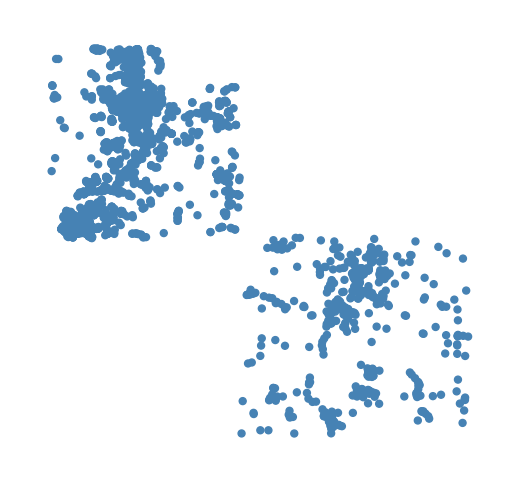

In [30]:
# map points
# convert dataframe to geodataframe
gdf_sites = gpd.GeoDataFrame(df_sites, geometry=gpd.points_from_xy(df_sites.Longitude.astype(float), df_sites.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdf_sites)

C:\Users\rjame\anaconda3\lib\site-packages\geoplot\geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

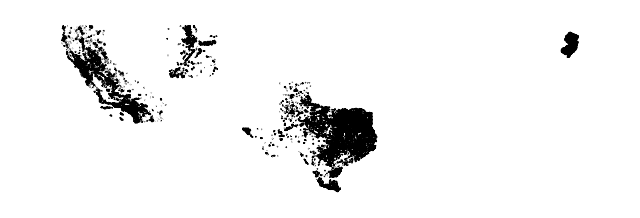

In [31]:
# map polygons
gplt.polyplot(gdf_poly)

AttributeError: 'LineString' object has no attribute 'exterior'

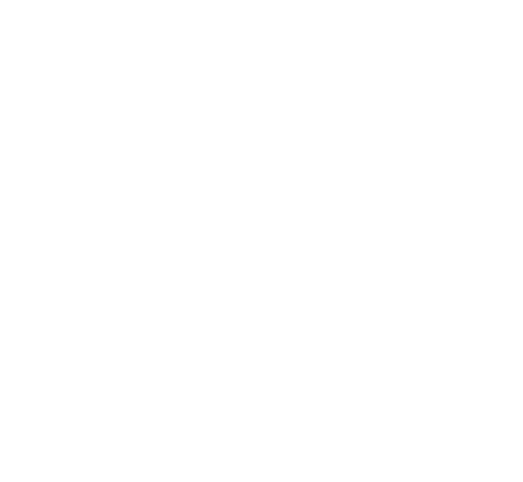

In [32]:
# map Lines
gplt.polyplot(gdf_lines)

In [ ]:
# # Issue of ESRI Shapefile does not support datetime fields

# dfs['minTimeFrameStart'] = pd.to_datetime(dfs['minTimeFrameStart'], errors = 'coerce')
# dfs['maxTimeFrameEnd'] = pd.to_datetime(dfs['maxTimeFrameEnd'], errors = 'coerce')
# print(dfs['minTimeFrameStart'].min())
# print(dfs['maxTimeFrameEnd'].max())

### Testing simplify geometry